# Aim of R&D into Python GLMs:

- Do they perform better compared to the Emblem models

- How much faster can they be made in Python if there is a trade-off with model accuracy?

- Allowing models to be updated more frequently-maybe be used for slightly 'less important' models (such as TTC) if model performance is slightly worse.

## Metrics to compare

Emblem Highest Gini: **0.4** (0.7 in Radar which value do we benchmark), best MSE: **0.101449177**


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import sklearn

## When loading in the data to ensure like for like comparisons to the models built in Emblem we loaded the training and testing sets in separately.

This is as they were produced for Emblem data files, however if this process was to be used in future the full dataset could be loaded in all at once and suitable splits (80/20 etc) could be performed using the 'train_test_split' function-this is standard procedure for such python based models

In [ ]:
#R:\Pricing & Actuarial\Pricing\Personal Lines Pricing - Motor\Technical\8. Optimisation\6. CDL\1. Jan22\2. Modelling\1. Cancellation\1. Data
Saga_NB_df = pd.read_csv(r"R:\Pricing & Actuarial\Pricing\Personal Lines Pricing - Motor\Technical\8. Optimisation\6. CDL\1. Jan22\2. Modelling\Python\Cancellation_NB_Saga_Nov19-Nov21_train.csv")

Saga_NB_test_df = pd.read_csv(r"R:\Pricing & Actuarial\Pricing\Personal Lines Pricing - Motor\Technical\8. Optimisation\6. CDL\1. Jan22\2. Modelling\Python\Cancellation_NB_Saga_Nov19-Nov21_test.csv")



### Looking at the shapes of the training and testing datasets (80/20 split), the test data set has an extra column 'validation_set'

In [ ]:
print('Train set shape: ',Saga_NB_df.shape)

print('Test set shape: ',Saga_NB_test_df.shape)

## The library (and Python in general) doesn't work well with spaces in the column names, so must replace any of the names with underscores or similar convention.

In [ ]:
columns = Saga_NB_df.columns
new_column_headers = []
for val in columns:
    altered_header = val.replace(" ", "_")
    #print(val)
    #print(altered_header)
    new_column_headers.append(altered_header)

Saga_NB_df.columns = new_column_headers
print(Saga_NB_df.columns)

## Performing feature importance analysis. To decide which features should be included. 

This is an automated script that will on any dataset (different response variables: Conversion, Retention etc) with the same factor sets and bandings. This can help to give a base starting point to work from, similar to the stepwise regression tool in Emblem. Combining this with knowledge of the data and model types will help to include the most important features for prediction.

## Dropping columns from the dataset that are unecessary-could be that they aren't GIPP compliant or that they were used in production of the train/test datasets and arent useful for model production.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#These are factors that either aren't GIPP compliant, allowed to be used in this stage of modelling  (may be added in overlays etc) or are part of the setup of the dataset, not important for modelling.
Saga_NB_dropped_unnecessary_df = Saga_NB_df.drop(columns=['Weight', 'set', 'Add_Driver_Sex', 'Main_Driver_Sex', 'Main_Driver_Age_Months'])

Saga_NB_dropped_unnecessary_test_df = Saga_NB_test_df.drop(columns=['Weight', 'set', 'Add_Driver_Sex', 'Main_Driver_Sex', 'Main_Driver_Age_Months', 'validation_set'])

#Check shapes of the dataframe.
print(Saga_NB_dropped_unnecessary_df.shape, Saga_NB_dropped_unnecessary_test_df.shape)



## Encode the categorical variables-required for feature importance

### Producing the list of bandings in correct order like from Radar/Emblem. This must be done for all factors!!!

Using Ordinal Encoder, generally not the best practice for factors with no meaningful order however the script was build to fit in the Radar architecture.

Was completed for Broker factors but missing some from Direct/John Lewis.


------------------------------------------------------------------------------------------------------------------------------------------------------------


This code is to produce the bandings (as they are in Radar)for annual mileage and can be adapted for the various features not included. For features with string based levels this banding list requires a manual approach.

In [ ]:
annual_mileage_strings = []
for i in range(0,31,1):
    annual_mileage_strings.append(str(i))
print(annual_mileage_strings)


### Viewing the trainign dataset after the unnecessary columns have been dropped-to ensure all looks correct

In [ ]:
Saga_NB_dropped_unnecessary_df

## This is where the Ordinal encoding function was used (forced for some un-ordered feature levels) to mimic the creation of bandings that occurs in Radar.

This is the list of factors from the Saga NB dataset that will be used to create the Cancellation GLM, the list of bandings created for each factor are also seen (created using the for loop seen above or manually for the text levels).

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

Saga_NB_transformed_df = Saga_NB_dropped_unnecessary_df[[
                            'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                            'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                            'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                            'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                            'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                            'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                            'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                            'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                            'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                            'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                            'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                            'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                            'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                            'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']]
ordinal_encoder = OrdinalEncoder(categories=[[-1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87],
                                             ['Comp', 'TPFT'],
                                             [0,1,2,3,4,5,6],
                                             ['Car Park', 'Carport', 'Garaged', 'Locked Building', 'Locked Compound', 'On Drive', 'Private Property', 'Public Road', 'Third Party Premises', 'Unlocked Building', 'Unlocked Compund', 'Business Address', 'N/A'],
                                             [0,1,2,3,4,5,6,7,8,9], #Missing? Can't mix int and strings... what to do?
                                             [0,1,2,3,4,5,6,7,8,9],
                                             [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
                                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                                             ['SDP', 'SDP & C', 'Class 1', 'Class 2', 'Class 3', 'Class 1 (Policyholder Only)', 'Class 1 (Spouse Only)'],
                                             ['1 - 1000', '1001 - 2000', '2001 - 3000', '3001 - 4000', '4001 - 5000', '5001 - 6000', '6001 - 7000', '7001 - 8000', '8001 - 9000', '9001 - 10000', '10001 - 11000', '11001 - 12000', '12001 - 13000', '13001 - 14000', '14001 - 15000', '15001 - 16000', '16001 - 17000', '17001 - 18000', '18001 - 19000', '19001 - 20000', '20001 - 21000', '21001 - 22000', '22001 - 23000', '23001 - 24000', '24001 - 25000', '25001 - 26000', '26001 - 27000', '27001 - 28000', '28001 - 29000', '29001 - 30000', 'Over 30000'],
                                             ['IOD', '-15+', '-10 to -14', '-5 to -9', '0 to -4',  '1 to 5','6+'],
                                             ['IOD', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                                             ['IOD', '0', '1', '2', '3', '4'],
                                             ['IOD', '17 to 24', '25 to 29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65+'],
                                             ['IOD', '0', '1', '2', '3', '4'],
                                             [0,1,2,3,4,5],
                                             ['Any', 'I&1', 'I&2', 'I&3', 'I&F', 'I&P', 'I&S', 'IOD'],
                                             [0,1,2,3,4,5],
                                             ['N', 'Y'],
                                             [0,1,2,3,4,5,6,7,8,9], 
                                             ['No Conviction', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
                                             [0,1,2,3],#Missing? Can't mix int and strings... what to do?
                                             ['Not in Employment', 'Armed Services', 'Bar/Restaurant', 'Building & Construction', 'Driving/Motor Trade', 'Education/Research', 'Farming/Animals', 'Government/Public Services', 'Healthcare', 'Leisure/Beauty', 'Manual/Unskilled', 'Office/Professional', 'Other', 'Security Cash & Courier', 'Skilled', 'Sports/Entertainment'],
                                             ['Common Law', 'Divorced', 'Married', 'Partnered', 'Separated', 'Single', 'N/A'],
                                             ['Full (UK)', 'International', 'Provisional', 'Foreign', 'Restricted < 3 Years', 'Restricted >= 3 Years'],
                                             ['N/A', 'N', 'Y'],
                                             ['Employed', 'Employed (Temporary)','Financially Assisted', 'Household Duties', 'In Full Or Part Time Education', 'Independent Means', 'Unemployed', 'Own Company', 'Retired', 'Self Employed', 'Voluntary Work', 'Contractor', 'Missing'],
                                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
                                             ['Agriculture & Animals', 'Antique / Arts Trade', 'Armed Services', 'Aviation', 'Blue Collar', 'Business Professional', 'Cash Collector', 'Child Care', 'Construction', 'Courier', 'Craftsman', 'Design', 'Education and Training ', 'Electrical', 'Emergency Services', 'Engineering', 'Entertainment & Media', 'Finance & Insurance', 'Food', 'Government and Agencies', 'Healthcare', 'Holiday', 'Hotel Pub & Restaurant', 'Installation', 'IT', 'Leisure & Beauty', 'Maintenance & Repair', 'Manufacturing', 'Marketing', 'Mining and Fuel', 'Not in Employment', 'Office Administration', 'Other', 'Parks & Gardens', 'Photography', 'Property', 'Public Service', 'Publishing', 'Retail Food', 'Retail Sales', 'Science', 'Security', 'Social Services', 'Telecommunications', 'Tradesman', 'Transport', 'Missing'],
                                             [0,1,2,3,4,5,6,7,8,9],
                                             ['0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5', 'No Conviction'],
                                             ['1 to 2', '2 to 3', '3 to 4', '4 to 5', '0 to 1', 'No Claim'],
                                             ['1 to 2', '2 to 3', '3 to 4', '4 to 5', '0 to 1', 'No Claim'],
                                             ['0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5', 'No Claim'],
                                             [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 
                                             ['AJ-NB', 'AJ_RC', 'NB', 'RB', 'RC'],
                                             ['No Claim', '1', '2', '3', '4', '5'],
                                             ['No Claim', '1', '2', '3', '4', '5'],
                                             ['No Claim', '1', '2', '3', '4', '5'],
                                             ['No Claim', '1', '2', '3', '4', '5'],
                                             ['No Claim', '1', '2', '3', '4', '5'],
                                             ['No Claim', '1', '2', '3', '4', '5+'], 
                                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                                             ['Proposer', 'Spouse', 'Common-Law Partner', 'Family', 'Company', 'Leased Vehicle', 'Other'],
                                             ['Proposer', 'Spouse', 'Common-Law Partner', 'Family', 'Company', 'Leased Vehicle', 'Other'],
                                             ['Under 1000', '1000 - 1999', '2000 - 2999', '3000 - 3999', '4000 - 4999', '5000 - 5999', '6000 - 6999', '7000 - 7999', '8000 - 8999', '9000 - 9999', '10000 - 10999', '11000 - 11999', '12000 - 12999', '13000 - 13999', '14000 - 14999', '15000 - 15999', '16000 - 16999', '17000 - 17999', '18000 - 18999', '19000 - 19999', '20000-20999', '21000-21999', '22000-22999', '23000-23999', '24000-24999', '25000-25999', '26000-26999', '27000-27999', '28000-28999', '29000-29999', '30000-30999', '31000-31999', '32000-32999', '33000-33999', '34000-34999', '35000-35999', '36000-36999', '37000-37999', '38000-38999', '39000-39999', '40000-40999', '41000-41999', '42000-42999', '43000-43999', '44000-44999', '45000-45999', '46000-46999', '47000-47999', '48000-48999', '49000-49999', '50000+'],
                                             ['0', '1', '2', '3', '4', '5', '6+', 'Default'],
                                             ['0 to 99', '100 to 199', '200+', 'Default'],
                                             ['0-74', '75-84','85-94', '95-104', '105-114', '115-124', '125-134', '135-144', '145+', 'Default'],
                                             ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', 'Default']])
vehicle_value_encoded = ordinal_encoder.fit_transform(Saga_NB_dropped_unnecessary_df[[
                            'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                            'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                            'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                            'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                            'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                            'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                            'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                            'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                            'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                            'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                            'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                            'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                            'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                            'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']])

## Viewing the array of encoded values to initially check the process

In [ ]:
vehicle_value_encoded

## Applying the encoded columns to the overall dataset (has the unecessary columns removed)

In [ ]:
Saga_NB_transformed_df[[
                        'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                        'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                        'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                        'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                        'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                        'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                        'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                        'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                        'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                        'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                        'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                        'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                        'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                        'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']] = vehicle_value_encoded
Saga_NB_dropped_unnecessary_df[[
                                'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                                'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                                'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                                'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                                'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                                'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                                'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                                'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                                'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                                'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                                'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                                'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                                'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                                'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']] = Saga_NB_transformed_df[[
                                                                                                                                                                'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                                                                                                                                                                'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                                                                                                                                                                'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                                                                                                                                                                'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                                                                                                                                                                'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                                                                                                                                                                'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                                                                                                                                                                'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                                                                                                                                                                'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                                                                                                                                                                'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                                                                                                                                                                'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                                                                                                                                                                'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                                                                                                                                                                'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                                                                                                                                                                'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                                                                                                                                                                'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']]

## Viewing the training dataset where the Ordinal Encoder has been appplied.

In [ ]:
Saga_NB_dropped_unnecessary_df

## Same for Test dataset

In [ ]:

Saga_NB_transformed_test_df = Saga_NB_dropped_unnecessary_test_df[[
                            'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                            'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                            'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                            'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                            'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                            'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                            'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                            'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                            'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                            'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                            'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                            'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                            'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                            'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']]


vehicle_value_encoded_test = ordinal_encoder.fit_transform(Saga_NB_dropped_unnecessary_test_df[[
                                                                                                'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                                                                                                'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                                                                                                'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                                                                                                'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                                                                                                'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                                                                                                'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                                                                                                'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                                                                                                'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                                                                                                'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                                                                                                'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                                                                                                'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                                                                                                'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                                                                                                'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                                                                                                'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']])

Saga_NB_transformed_test_df[[
                            'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                            'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                            'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                            'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                            'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                            'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                            'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                            'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                            'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                            'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                            'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                            'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                            'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                            'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']] = vehicle_value_encoded_test
Saga_NB_dropped_unnecessary_test_df[[
                                    'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                                    'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                                    'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                                    'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                                    'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                                    'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                                    'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                                    'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                                    'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                                    'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                                    'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                                    'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                                    'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                                    'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']] = Saga_NB_transformed_test_df[[
                                                                                                                                                                        'AgePassedTest', 'Cover', 'Duration', 'Garaged', 'NCDAllowed',
                                                                                                                                                                        'NCDDifference', 'RegistrationYear', 'VehicleAgeatPurchase', 
                                                                                                                                                                        'YearsOwned', 'Class_of_Use', 'Annual_Mileage', 'Age_Difference',
                                                                                                                                                                        'Add_Driving_Experience', 'Add_Other_Vehs_Owned', 'Add_Driver_Age',
                                                                                                                                                                        'Add_Access_to_Other_Vehs', 'Access_to_Other_Vehs', 'PDR_Code',
                                                                                                                                                                        'Other_Vehs_Owned', 'NCD_Protected', 'NCD_Earned', 'Most_Severe_Conviction',
                                                                                                                                                                        'Main_UK_Residency', 'Main_Occupation', 'Main_Marital_Status', 
                                                                                                                                                                        'Main_Licence_Type', 'Main_Full_Time_Employed', 'Main_Employment_Type',
                                                                                                                                                                        'Main_Driving_Experience_Months', 'Main_Employer_Business', 'Main_Driving_Experience',
                                                                                                                                                                        'Latest_Conviction', 'Latest_Fault_Accident_Claim','Latest_Non_Fault_Accident_Claim',
                                                                                                                                                                        'Latest_Windscreen_Claim','Main_Driver_Age', 'Transaction_Type', 'Tot_Windscreen_Claims', 
                                                                                                                                                                        'Tot_Vandalism_Claims', 'Tot_Theft_Claims', 'Tot_Non_Fault_Accident_Claims', 
                                                                                                                                                                        'Tot_Fire_Claims', 'Tot_Fault_Accident_Claims', 'Vehicle_Age', 'Vehicle_Keeper', 
                                                                                                                                                                        'Vehicle_Owner', 'Vehicle_Value', 'Saga_Years_with_Broker', 'SagaCais', 'SagaFactor', 'SagaQuoteLag']]

## Scaling the features

This step is important to bring all the factors onto the same scale-this is to ensure that all factors are given the opportunity to be predictive even if the levels within the factor are on a smaller scale.

For example Main_Driver_Age is a on a scale from 17-100 whereas NCD_Earned is on a scale from 0-9 however an increase in NCD_Earned from 0 years to 9 years is a larger change than Main_Driver_Age increasing from 17-26 (same 9 years) relative to the factor in question.

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
#Saga_NB_dropped_unnecessary_arr = Saga_NB_dropped_unnecessary_df.to_numpy()
Saga_NB_dropped_unnecessary_scaled = scaler.fit_transform(Saga_NB_dropped_unnecessary_df)
Saga_NB_dropped_unnecessary_scaled_df = pd.DataFrame(Saga_NB_dropped_unnecessary_scaled)
Saga_NB_dropped_unnecessary_scaled_df.columns = Saga_NB_dropped_unnecessary_df.columns


## Viewing the scaled train data-ensuring all factors have been scaled the same.

In [ ]:
Saga_NB_dropped_unnecessary_scaled_df

## Same for test dataset 
We don't want to re-define the scaler for this dataset, or fit it to it just use the transform from the training data

In [ ]:
Saga_NB_dropped_unnecessary_test_scaled = scaler.transform(Saga_NB_dropped_unnecessary_test_df)
Saga_NB_dropped_unnecessary_scaled_test_df = pd.DataFrame(Saga_NB_dropped_unnecessary_test_scaled)
Saga_NB_dropped_unnecessary_scaled_test_df.columns = Saga_NB_dropped_unnecessary_test_df.columns

# Feature selection approaches

### Correlated factors

### Simple plot including all factors
Darkest and lightest colours show the highest correlations between two factors in the data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

corr_matrix = Saga_NB_dropped_unnecessary_scaled_df.corr()

plt.figure(figsize=(15,12))
sn.heatmap(corr_matrix, annot=False)
plt.show()

## A visual representation of the factors with the highest correlation coefficients.
If two factors are highly correlated only one most likely needs to be included.

Adding interactivity so the names of the factors come up when you hover over it.

In [ ]:
dfCorr = Saga_NB_dropped_unnecessary_scaled_df.corr()
filteredDf = dfCorr[((dfCorr >= 0.5) | (dfCorr <= -0.5)) & (dfCorr !=1.000)]
#This line can check to see if it is only the same factors that have a correlation equal to 1.
#filteredDf = dfCorr[(dfCorr == 1.000)]

plt.figure(figsize=(30,15))
sn.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

## Listing the highest correlated factors

In [ ]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates().dropna()
    return xFlattened

corrFilter(Saga_NB_dropped_unnecessary_scaled_df, 0.7)

# Split data into X and y for train and test data.

In [ ]:
X_train = Saga_NB_dropped_unnecessary_scaled_df.drop(columns=['cancelled'])


y_train = Saga_NB_dropped_unnecessary_scaled_df['cancelled']

X_test = Saga_NB_dropped_unnecessary_scaled_test_df.drop(columns=['cancelled'])

y_test = Saga_NB_dropped_unnecessary_scaled_test_df['cancelled']

feature_names = [val for val in X_train]



## Wrapper Feature Selection Methods 

Python has built-in functions capable of implementing these two feature selection methods below in only a few lines of code. The **mlxtend** library contains built-in implementation for most wrapper methods based feature selection techniques. 

**from mlxtend.feature_selection import SequentialfeatureSelector as SFS**

## Forward Selection method

In [ ]:
## Function accepts data, target and significance level as arguments and returns the final list of significant features 
## based on p-values
import statsmodels.api as sm
data = Saga_NB_dropped_unnecessary_scaled 
target = Saga_NB_dropped_unnecessary_scaled_df['cancelled']

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [ ]:
forward_selection(X_train, y_train)

## Backward Elimination method

In [ ]:
import statsmodels.api as sm
data = Saga_NB_dropped_unnecessary_scaled 
target = Saga_NB_dropped_unnecessary_scaled_df['cancelled']

def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [ ]:
backward_elimination(X_train, y_train)

## Dropping the response variable to perform the feature importance

In [ ]:
Saga_NB_feature_importance = Saga_NB_dropped_unnecessary_scaled_df.drop(columns = ['cancelled'])

## Univariate feature importance

Only consider individual factors contributions to the models predictions-not the combination of various factors in an overall predictive effort.

In [ ]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_regression 

kbest = SelectKBest(score_func=f_regression, k=15)
kbest.fit(Saga_NB_feature_importance, Saga_NB_dropped_unnecessary_scaled_df['cancelled'])

#print("Feature scores", kbest.scores_)

features_selected_k_best = list(Saga_NB_feature_importance.columns[kbest.get_support()])

print("Selected Features", features_selected_k_best)
print()
print("Removed Features", list(Saga_NB_feature_importance.columns[~kbest.get_support()]))


## Using Random Forests' (tree based model) built in feature ranking.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import time


## RandomForestClassifier-default hyperparameter build.

In [ ]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

### Standard feature importance (Mean Decrease Impurity)

In [ ]:
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
forest_importances.nlargest(len(Saga_NB_transformed_df)).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Can change the value withink the nlargest() function to give the top n most 'important' features.

In [ ]:
RF_MDI = []
for val in forest_importances.nlargest(20).index:
    RF_MDI.append(val)

RF_MDI_interaction_check = []
for val in forest_importances.nlargest(5).index:
    RF_MDI_interaction_check.append(val)

### Feature importance based on feature permutation-this helps to remove the bias to high cardinality (features with lots of factor levels) features.

Increasing the 'n_repeats' improves the reliability of the feature importance ranking algorithm however increases the run time. n_repeats = 10: 50 seconds etc.

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)

forest_importances.nlargest(len(Saga_NB_transformed_df)).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
RF_perm = []
for val in forest_importances.nlargest(20).index:
    RF_perm.append(val)
    
RF_perm_interaction_check = []
for val in forest_importances.nlargest(5).index:
    RF_perm_interaction_check.append(val)

## GradientBoostingClassifier

### Look at hyperparameters to tune them.

In [ ]:
#Again change Saga_NB_transformed_df to Saga_NB_dropped_unnecessary_df

feature_names = [val for val in X_train]
gbm = GradientBoostingClassifier(random_state=0)
gbm.fit(X_train, y_train)

In [ ]:
importances_gbm = gbm.feature_importances_
#std = np.std([tree.feature_importances_ for tree in gbm.estimators_], axis=0)

gbm_importances = pd.Series(importances_gbm, index=feature_names)

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
gbm_importances.nlargest(len(Saga_NB_transformed_df)).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
GBM_MDI = []
for val in forest_importances.nlargest(20).index:
    GBM_MDI.append(val)
    
GBM_MDI_interaction_check = []
for val in forest_importances.nlargest(5).index:
    GBM_MDI_interaction_check.append(val)

## Combining the factors identified by each Model and method.

Copy is required to search for interactions...

In [ ]:
important_factors=[]
for val in RF_MDI:
    if val not in important_factors:
        important_factors.append(val)
    else:
        pass
for val in RF_perm:
    if val not in important_factors:
        important_factors.append(val)
    else:
        pass
for val in GBM_MDI:
    if val not in important_factors:
        important_factors.append(val)
    else:
        pass
for val in features_selected_k_best:
    if val not in important_factors:
        important_factors.append(val)
    else:
        pass
        
important_factors_copy = important_factors

In [ ]:
print(important_factors)
print(len(important_factors))

## Looking for interactions

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias=False, interaction_only=True)

## Chi squared tests

This method is similar to the Emblem tool for searching for interactions, only considers two way interactions but could be extended to consider 3-way.

In [ ]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

### Can alter the confidence level (set at maximum to 95%) by being more lenient to view more factors interacting.

In [ ]:
highest_chances_of_interactions = []
#Producing a contingency table from the dataset
for var_1 in important_factors:
    for var_2 in important_factors_copy:
        if var_1 != var_2:
            contigency_pct = pd.crosstab(Saga_NB_dropped_unnecessary_df[var_1], Saga_NB_dropped_unnecessary_df[var_2], normalize='index')
            c, p, dof, expected = chi2_contingency(contigency_pct)
            if p<0.05:
                highest_chances_of_interactions.append([var_1, var_2])

In [ ]:
highest_chances_of_interactions

## These just seem to be the small categorical variables...

## Plot based 

Look at most likely ranked interaction by Chi squared testing and look at top 5 factors from each factor importance.

In [ ]:
important_factors_interaction_check=[]
for val in RF_MDI_interaction_check:
    if val not in important_factors_interaction_check:
        important_factors_interaction_check.append(val)
    else:
        pass
for val in RF_perm_interaction_check:
    if val not in important_factors_interaction_check:
        important_factors_interaction_check.append(val)
    else:
        pass
for val in GBM_MDI_interaction_check:
    if val not in important_factors_interaction_check:
        important_factors_interaction_check.append(val)
    else:
        pass
    

In [ ]:
important_factors_interaction_check

In [ ]:
interaction_plot_df = Saga_NB_dropped_unnecessary_scaled_df[['AgePassedTest', 'Main_Driver_Age', 'Annual_Mileage', 'Vehicle_Age', 'Vehicle_Value', 'SagaCais', 'Saga_Years_with_Broker', 'PDR_Code', 'SagaQuoteLag', 'NCD_Protected', 'cancelled']]

In [ ]:
interaction_plot_df['cancelled'].loc[interaction_plot_df['cancelled']==1] = 'Cancelled';
interaction_plot_df['cancelled'].loc[interaction_plot_df['cancelled']==0] = 'Not Cancelled';


## Pairplot of the top 10 ranked features (importance).

This plot has been colour coded on whether the policy was cancelled or not to attempt to view some interactions between two features

In [ ]:
sn.pairplot(interaction_plot_df, hue = 'cancelled', diag_kws={'bw': 0.01})

## Statsmodel in Python 

This is a Python library built specifically for statistics. Statsmodels is built on top of other Python libraries (NumPy, SciPy and matplotlib) but it contains more advanced functions for statistical testing and modelling. This library also supports specifying models usinf R-style formulas and pandas DataFrames.

In Python, libraries are used to refer to a collection of modules that are used repeatedly in various programs without the need of writing them from scratch. To import a library in Python the keyword **import** should be used. Python also allows us to change the names of modules and functions and name them as we want.The name given to the module or library in place of the original name is known as the alias and the keyword **as** should be used. 

For fitting a GLM the following statsmodels libraries need to be imported. 

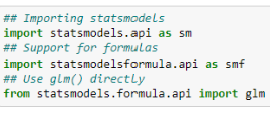

The process of fitting a GLM model in Python. 
1. Describe the model -> smf.glm("formula")
2. Fit the model -> .fit( ) 
3. Summarise the model -> .summary( ) 
4. Make model predictions -> .predict( ) 


Two ways in Python to describe the model used to build the GLM, use a formula or an array. The method chosen for the GLM building is the formula approach, which uses R-style formulas. 


Fitting the GLM takes three key arguements. 

## Fitting the GLM -  glm_model = smf.glm(**formula**, **data**, **family**) 


--------------------------------------------------------------------------------------------------------------------------------
### **formula** argument 

- The **formula** is where the response is modeled as a function of the explantory variables. In this case our model response is "cancelled". 

- Each explanatory variable is specified and separated with a plus sign. An important note is that the formula must be enclosed in quotation marks. 

An example formula is shown below.
### "cancelled ~ Tot_Non_Fault_Accident_Claims + YearsOwned + Saga_Years_with_Broker + Main_Driver_Age"

There are different ways that the explantory variables can be represented in the model. The two used for this GLM build are described below.
- **C(x1)**: treat x1 as a categorical variable 
- **x1*x2**: an interaction between x1 and x2 and the individual variables 

The example formula adjusted to how the explantory variables have been represented in this GLM model 

### "cancelled ~ C(Tot_Non_Fault_Accident_Claims) + C( YearsOwned) + C(Saga_Years_with_Broker) + C(Main_Driver_Age) + C(Vehicle_Age*Age_Difference)"

Note the reason for all variables fitted in the GML model being represented as categorical using C( ) is due to the bandings created at the start of this notebook where the Ordinal encoding function was used (forced for some un-ordered feature levels) to mimic the creation of bandings that occurs in Radar.

-------------------------------------------------------------------------------------------------------------------------------

### data arguement

This should be set as equal to the dataframe to be used in the model. When building models the traning dataset should be used and not the testing to avoid misleading results. 

For the GLM build in this notebook the testing data is in the dataframe **Saga_NB_dropped_unnecessary_scaled_df** so the data argument should be set as

### **data = Saga_NB_dropped_unnecessary_scaled_df**

-------------------------------------------------------------------------------------------------------------------------------

### family arguement

Family distributions are in the families namespace. The data used for this model is a Binary Data Type since 0, 1 and the family for this data type is Binomial( ). Each family has a default link but other link functions are available for each distribution. In this case the default link function for Binomial is .logit( ) and since it is the default it does not need to be specified in the GLM fit. 

### family = sm.families.Binomial( )

-------------------------------------------------------------------------------------------------------------------------------

### Fitting the GLM

### glm_model = smf.glm("cancelled ~ C(Tot_Non_Fault_Accident_Claims) + C( YearsOwned) + C(Saga_Years_with_Broker) + C(Main_Driver_Age) + C(Vehicle_Age*Age_Difference)", data = Saga_NB_dropped_unnecessary_scaled_df, family = sm.families.Binomial()).fit() 

--------------------------------------------------------------------------------------------------------------------------------

### Summarising the model and predictions 

To view the results of the model fit use the summary method. 

### glm_model.summary( ) 

This table provides the main information on the model fit such as, model description, statistics and estimated parameters. 

To view the predictions of the model the test data should be specified which should contain all the variables included in the final model. Earlier in this notebook the training data was specified in X_train and y_train then the testing data split into  X_test and y_test. 

-------------------------------------------------------------------------------------------------------------------------------

## Fitting the GLM

Extract information from: Correlation, Feature importance and Interaction testing analyses to produce the first iteration of the model.

In [ ]:
overall_formula = ""
for feature in important_factors:
    formula_component = " C("+feature+") +"
    overall_formula+=formula_component

In [ ]:
overall_formula

## Converting back to the list to use in VIF

In [ ]:
factors_string = 'C(AgePassedTest) + C(Main_Driver_Age) + C(Annual_Mileage) + C(Vehicle_Age) + C(Vehicle_Value) + C(VehicleAgeatPurchase) + C(YearsOwned) + C(SagaQuoteLag) + C(SagaFactor) + C(SagaCais) + C(Saga_Years_with_Broker) + C(Garaged) + C(Age_Difference) + C(Add_Driver_Age) + C(Main_Occupation) + C(PDR_Code) + C(Class_of_Use) + C(Main_Marital_Status) + C(Latest_Fault_Accident_Claim) + C(NCD_Protected) + C(Main_Employment_Type) + C(NCD_Earned) + C(Main_Full_Time_Employed) + C(Transaction_Type) + C(NCDAllowed)'
factors_string.replace("+", " ,").replace("'","").replace('C', '').replace('(', '').replace(')','')

# Defining the model

Formula based approach, alternatively can use an array based method.

In [ ]:
mod_initial  = smf.glm(formula = "cancelled ~ (C(AgePassedTest) + C(Main_Driver_Age) + C(Annual_Mileage) + C(Vehicle_Age) + C(Vehicle_Value) + C(VehicleAgeatPurchase) + C(SagaQuoteLag) + C(YearsOwned) + C(Random5) + C(SagaFactor) + C(SagaCais) + C(Saga_Years_with_Broker) + C(Garaged) + C(Age_Difference) + C(Add_Driver_Age) + C(Main_Occupation) + C(PDR_Code) + C(Class_of_Use) + C(Main_Marital_Status) + C(Latest_Fault_Accident_Claim) + C(NCD_Protected) + C(Main_Full_Time_Employed) + C(Main_Employment_Type) + C(Transaction_Type) + C(NCD_Earned) + C(NCDAllowed))", data = Saga_NB_dropped_unnecessary_scaled_df, family=sm.families.Binomial()).fit()

## Ensuring all possible levels are defined for variables included

This is to ensure when the 'test' set is given to the fitted model there are no unknown factor levels that will cause an error.

In [ ]:
#Perform this same union for any factors included.

all_AgePassedTest = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["AgePassedTest"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["AgePassedTest"])))
all_YearsOwned = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["YearsOwned"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["YearsOwned"])))
all_Class_of_Use = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Class_of_Use"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Class_of_Use"])))
all_Annual_Mileage = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Annual_Mileage"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Annual_Mileage"])))
all_Age_Difference = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Age_Difference"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Age_Difference"])))
all_Add_Driver_Age = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Add_Driver_Age"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Add_Driver_Age"])))
all_Access_to_Other_Vehs = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Access_to_Other_Vehs"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Access_to_Other_Vehs"])))
all_PDR_Code = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["PDR_Code"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["PDR_Code"])))
all_NCD_Protected = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["NCD_Protected"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["NCD_Protected"])))
all_NCDAllowed = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["NCDAllowed"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["NCDAllowed"])))
all_NCD_Earned = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["NCD_Earned"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["NCD_Earned"])))
all_Main_Full_Time_Employed = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Main_Full_Time_Employed"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Main_Full_Time_Employed"])))
all_Main_Occupation = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Main_Occupation"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Main_Occupation"])))
all_Latest_Fault_Accident_Claim = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Latest_Fault_Accident_Claim"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Latest_Fault_Accident_Claim"])))
all_Tot_Non_Fault_Accident_Claims = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Tot_Non_Fault_Accident_Claims"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Tot_Non_Fault_Accident_Claims"])))
all_Main_Driver_Age = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Main_Driver_Age"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Main_Driver_Age"])))
all_Vehicle_Age = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Vehicle_Age"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Vehicle_Age"])))
all_VehicleAgeatPurchase = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["VehicleAgeatPurchase"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["VehicleAgeatPurchase"])))
all_Vehicle_Value = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Vehicle_Value"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Vehicle_Value"])))
all_Vehicle_Owner = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Vehicle_Owner"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Vehicle_Owner"])))
all_Saga_Years_with_Broker = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Saga_Years_with_Broker"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Saga_Years_with_Broker"])))
all_SagaCais = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["SagaCais"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["SagaCais"])))
all_SagaFactor = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["SagaFactor"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["SagaFactor"])))
all_SagaQuoteLag = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["SagaQuoteLag"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["SagaQuoteLag"])))
all_Transaction_Type = sorted(set(Saga_NB_dropped_unnecessary_scaled_df["Transaction_Type"]).union(set(Saga_NB_dropped_unnecessary_scaled_test_df["Transaction_Type"])))


# Buidling the first iteration of the model with solo factors returning from factor importance checks and model/industry knowledge (while monitoring the test Gini).

### *Ensuring the prediction remains as a probability not a classifier.*


Adding Main_Driver_Age means the output becomes binary... why? Can't have Main_Driver_Age and Add_Driver_Age in the model together...

Can't have Main_Driver_Age with Age_Difference in the same model...

In [ ]:
import sklearn

mod_solo_factors = smf.glm(formula = "cancelled ~ (C(YearsOwned, levels = all_YearsOwned) + C(Saga_Years_with_Broker, levels = all_Saga_Years_with_Broker) + C(Main_Driver_Age, levels = all_Main_Driver_Age) + C(Main_Occupation, levels = all_Main_Occupation) + C(Latest_Fault_Accident_Claim, levels = all_Latest_Fault_Accident_Claim) + C(NCD_Earned, levels = all_NCD_Earned) + C(NCDAllowed, levels = all_NCDAllowed) + C(NCD_Protected, levels = all_NCD_Protected) + C(VehicleAgeatPurchase, levels = all_VehicleAgeatPurchase) + C(SagaQuoteLag, levels = all_SagaQuoteLag) + C(SagaCais, levels = all_SagaCais) + C(PDR_Code, levels = all_PDR_Code) +  C(Vehicle_Age, levels = all_Vehicle_Age) + C(Class_of_Use, levels = all_Class_of_Use) + C(Main_Full_Time_Employed, levels = all_Main_Full_Time_Employed) + C(Annual_Mileage, levels = all_Annual_Mileage) + C(Vehicle_Value, levels = all_Vehicle_Value) + C(Transaction_Type, levels = all_Transaction_Type) + C(Vehicle_Owner, levels = all_Vehicle_Owner))", data = Saga_NB_dropped_unnecessary_scaled_df, family=sm.families.Binomial()).fit()
y_predict_solo_factors = mod_solo_factors.predict(X_test)

auc_Saga_NB = sklearn.metrics.roc_auc_score(y_test, y_predict_solo_factors)
gini_Saga_NB = (2*auc_Saga_NB)-1
print('Gini value: ',gini_Saga_NB)

mse = sklearn.metrics.mean_squared_error(y_predict_solo_factors, y_test)
#model_accuracy = (len(y_test) - len(y_test[y_predict_solo_factors_model_accuracy!=y_test]))/len(y_test)
print('MSE: '+ str(float(mse)))

In [ ]:
y_predict_solo_factors

## Best initial performance

Can check each itertion against this.

Max Gini: **0.4592546267408144**

Min MSE: **0.10264240720900086**

## Evaluating the model

To evaluate the model performance we must test the fitted model on the out-sample (test) set of data to see how it performs-we must call the predict function on this 'X_test' data to give the 'y_predict' values.

## Plotting the gains/AUC curve

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test,  y_predict_solo_factors)
auc = sklearn.metrics.roc_auc_score(y_test, y_predict_solo_factors)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Calculating the Gini coefficient

# Using AUC and performing a numerical operation to retrieve the Gini Coefficient.

In [ ]:
from sklearn import metrics
auc_Saga_NB = metrics.roc_auc_score(y_test, y_predict_solo_factors)
gini_Saga_NB = (2*auc_Saga_NB)-1
print(gini_Saga_NB)

## Add interactions and perform predictions and scoring each time/iteratively to test model performance.

Try out the ones ranked by Chi squared values that seem logical.

In [ ]:
highest_chances_of_interactions

## Test any other factors that are likely to interact for this model type (from the list of important factors or any others)

In [ ]:
important_factors

## A large benefit from building the GLMs in Python, other than the much quicker rate of build, is the fact that you can produce metrics for model performance on the testing data instantly-don't have to import and plug into Radar to retrieve this.

Meaning that iterations of a model can be built at much faster rates compared to the Emblem/Radar architecture. This instant metric calculation is shown below where the Gini score of the model on the test data set is retrieved instantly after fitting the model.

Max Gini: **0.4592546267408144**

Min MSE: **0.10264240720900086**

In [ ]:
import sklearn

mod_banded_interactions = smf.glm(formula = "cancelled ~ (C(Main_Full_Time_Employed*NCD_Protected) + C(Tot_Non_Fault_Accident_Claims, levels = all_Tot_Non_Fault_Accident_Claims) + C(YearsOwned, levels = all_YearsOwned) + C(Saga_Years_with_Broker, levels = all_Saga_Years_with_Broker) + C(Main_Driver_Age, levels = all_Main_Driver_Age) + C(Main_Occupation, levels = all_Main_Occupation) + C(Latest_Fault_Accident_Claim, levels = all_Latest_Fault_Accident_Claim) + C(NCD_Earned, levels = all_NCD_Earned) + C(NCDAllowed, levels = all_NCDAllowed) + C(NCD_Protected, levels = all_NCD_Protected) + C(VehicleAgeatPurchase, levels = all_VehicleAgeatPurchase) + C(SagaQuoteLag, levels = all_SagaQuoteLag) + C(SagaCais, levels = all_SagaCais) + C(PDR_Code, levels = all_PDR_Code) +  C(Vehicle_Age, levels = all_Vehicle_Age) + C(Class_of_Use, levels = all_Class_of_Use) + C(Main_Full_Time_Employed, levels = all_Main_Full_Time_Employed) + C(Annual_Mileage, levels = all_Annual_Mileage) + C(Vehicle_Value, levels = all_Vehicle_Value) + C(Transaction_Type, levels = all_Transaction_Type) + C(Vehicle_Owner, levels = all_Vehicle_Owner))", data = Saga_NB_dropped_unnecessary_scaled_df, family=sm.families.Binomial()).fit()
y_predict_interactions = mod_banded_interactions.predict(X_test)

auc_Saga_NB = sklearn.metrics.roc_auc_score(y_test, y_predict_interactions)
gini_Saga_NB = (2*auc_Saga_NB)-1
print('Gini value: ',gini_Saga_NB)

mse = sklearn.metrics.mean_squared_error(y_predict_interactions, y_test)
#model_accuracy = (len(y_test) - len(y_test[y_predict_solo_factors_model_accuracy!=y_test]))/len(y_test)
print('MSE: '+ str(float(mse)))

In [ ]:
y_predict_interactions

Max Gini with interaction: **0.460207346049289**

Min MSE with interaction: **0.10255822411394491**


#### Could try:

~~Main_Driver_Age*NCD_Protected~~: Makes output binary.

**Main_Marital_Status\*NCD_Protected**: Slight increase in test Gini.

~~SagaCais*Age_Difference~~: Makes output binary.

~~Vehicle_Age*SagaCais~~: Lowers Test Gini.

~~Vehicle_Age*SagaFactor~~: Lowers Test Gini.

**Main_Full_Time_Employed\*NCD_Protected**: Increases test Gini

~~Main_Full_Time_Employed*Main_Marital_Status~~: Lowers Test Gini

~~NCD_Protected*PDR_Code~~: Lowers Test Gini

~~Main_Marital_Status\*Transaction_Type~~: Lowers Test Gini

~~NCD_Protected\*Transaction_Type~~: Lowers Test Gini

~~Main_Full_Time_Employed\*Transaction_Type~~:Lowers Test Gini


## Are there any Solo factors not picked up by feature imporance but from experience are worth checking/testing:

Access_to_Other_Vehs: Lowered Test Gini.

Add_Other_Vehs_Owned: Lowered Test Gini

Latest_Conviction: Lowered Test Gini.

Latest_Non_Fault_Accident_Claim: Lowered Test Gini

**Tot_Non_Fault_Accident_Claims**: Increased Test Gini



## Plotting the ROC curve

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test,  y_predict_interactions)
auc = sklearn.metrics.roc_auc_score(y_test, y_predict_interactions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Variance Inflation Factor (VIF) 

Multicollinearity occurs when variables are correlated with each other. Including highly correlated variables in leads to an inflation of standard errors which can result in a coefficient not being statistically significant. There are different ways to check for multicolinearity but the most widely used diagnostic for multicolinearity is the variance inflation factor for each explanatory variable. The **statsmodel** library in Python can compute the VIF directly using the variance inflation factor function. 

Below is a code snippet that computes the VIF value for each of the variables listed. 

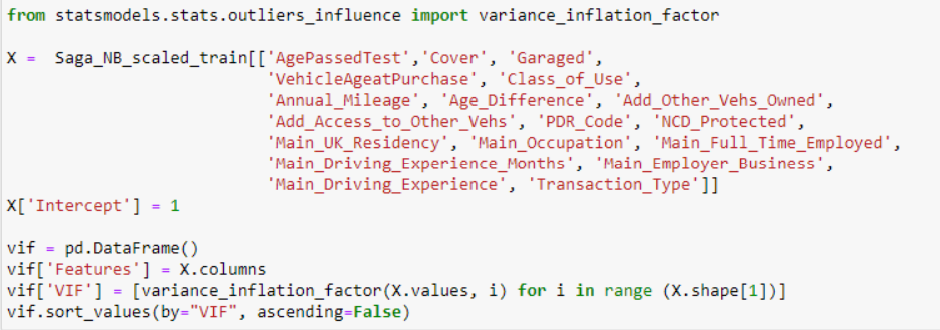


The code output displays a table which lists the variables and their calculated VIF value. 

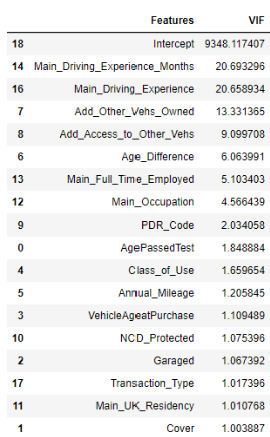

By removing the variable with the highest VIF value and computing the VIF value for variables again the VIF value decreases for the other variables 

## Multicollinearity Note

Typically a VIF value > 5 for variables indicates that they're suffering from multicollinearity. If multicollinearity is detected then the next step is to figure out if it you need to resolve it. The goal of the regression analysis will determine whether or not you actually need to resolve the multicollinearity issue. 

Multicollinearity impacts the coefficient estimates and the p-values but it doesn't impact predictions or goodness-of-fit statistics. If the exact relationship between the predictor variables and the resposne variable then the multicollinearity issue needs to be fixed. One way to do this is to remove one or more of the highly correlated variables and is the quickest fix. In the example above the variable with the highest VIF value was removed which led to a decrease in the other variables VIF values. 

A general rule of thumb for interpreting VIFs is a value between 1 and 5 indicates moderate correaltion between a predictor variable and other predictor variables in the model but is not severe enough to require attention. 

## Iterating over VIF values to check if model performance improves

In [ ]:
factors_used = ['Vehicle_Owner',  'Transaction_Type', 'Vehicle_Value', 'Annual_Mileage', 'Main_Full_Time_Employed', 'Class_of_Use', 'Vehicle_Age', 'PDR_Code', 'SagaCais', 'SagaQuoteLag', 'VehicleAgeatPurchase', 'NCD_Protected', 'NCDAllowed', 'NCD_Earned', 'Latest_Fault_Accident_Claim', 'Main_Occupation', 'Main_Driver_Age', 'Saga_Years_with_Broker', 'YearsOwned', 'Tot_Non_Fault_Accident_Claims']
len(factors_used)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X =  Saga_NB_dropped_unnecessary_scaled_df[['Vehicle_Owner',  'Transaction_Type', 'Vehicle_Value', 'Annual_Mileage', 'Main_Full_Time_Employed', 'Class_of_Use', 'Vehicle_Age', 'PDR_Code', 'SagaCais', 'SagaQuoteLag', 'VehicleAgeatPurchase', 'NCD_Protected', 'NCDAllowed', 'NCD_Earned', 'Latest_Fault_Accident_Claim', 'Main_Occupation', 'Main_Driver_Age', 'Saga_Years_with_Broker', 'YearsOwned', 'Tot_Non_Fault_Accident_Claims']]
X['Intercept'] = 1

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif.sort_values(by="VIF", ascending=False) 

## Remove high VIF scoring factors and re-test model performance

Removing Vehicle_Age: Decreases Test Gini score.

Removing YearsOwned: Decreased Test Gini Score.

Removing VehicleAgeatPurchase: Decreased Test Gini Score

Removing Main_Full_Time_Employed: Decreased Test Gini Score

Removing Main_Employment_Type: Decreased Test Gini Score

Removing NCD_Earned: Decreased Test Gini Score

Removing Add_Driver_Age: Decreased Test Gini Score

**Overall, no improvement on model performance.**

In [ ]:

mod_banded_VIF_check = smf.glm(formula = "cancelled ~ (C(Main_Full_Time_Employed*NCD_Protected) + C(Tot_Non_Fault_Accident_Claims, levels = all_Tot_Non_Fault_Accident_Claims) + C(YearsOwned, levels = all_YearsOwned) + C(Saga_Years_with_Broker, levels = all_Saga_Years_with_Broker) + C(Main_Driver_Age, levels = all_Main_Driver_Age) + C(Main_Occupation, levels = all_Main_Occupation) + C(Latest_Fault_Accident_Claim, levels = all_Latest_Fault_Accident_Claim) + C(NCD_Earned, levels = all_NCD_Earned) + C(NCDAllowed, levels = all_NCDAllowed) + C(NCD_Protected, levels = all_NCD_Protected) + C(VehicleAgeatPurchase, levels = all_VehicleAgeatPurchase) + C(SagaQuoteLag, levels = all_SagaQuoteLag) + C(SagaCais, levels = all_SagaCais) + C(PDR_Code, levels = all_PDR_Code) +  C(Vehicle_Age, levels = all_Vehicle_Age) + C(Class_of_Use, levels = all_Class_of_Use) + C(Main_Full_Time_Employed, levels = all_Main_Full_Time_Employed) + C(Annual_Mileage, levels = all_Annual_Mileage) + C(Vehicle_Value, levels = all_Vehicle_Value) + C(Transaction_Type, levels = all_Transaction_Type) + C(Vehicle_Owner, levels = all_Vehicle_Owner))", data = Saga_NB_dropped_unnecessary_scaled_df , family=sm.families.Binomial() ).fit()

y_predict_VIF_check = mod_banded_VIF_check.predict(X_test)

from sklearn import metrics
auc_Saga_NB = metrics.roc_auc_score(y_test, y_predict_VIF_check)
gini_Saga_NB = (2*auc_Saga_NB)-1
print('Gini score: ',gini_Saga_NB)

mse = sklearn.metrics.mean_squared_error(y_predict_VIF_check, y_test)
print('MSE: '+ str(float(mse)))


Gini to beat: **0.4596073460492829**

MSE to beat: **0.10255822411394491**

## Producing Emblem like plots for important/included factors

In [ ]:
plt.figure(figsize = (15,10))
sn.lineplot(X_test['Main_Driver_Age'], y_test)

sn.lineplot(X_test['Main_Driver_Age'], y_predict_interactions)
plt.title("Plot showing the actual vs predicted cancellation probability over Main_Driver_Age levels.")
ax.legend(["Actual", "Predicted"])

In [ ]:
plt.figure(figsize = (15,10))
plt.title("Plot showing the actual vs predicted cancellation probability over SagaFactor levels.")

sn.lineplot(X_test['SagaFactor'], y_test)
sn.lineplot(X_test['SagaFactor'], y_predict_interactions)
ax.legend(["Actual", "Predicted"])

In [ ]:
plt.figure(figsize = (15,10))
plt.title("Plot showing the actual vs predicted cancellation probability over Vehicle_Value levels.")
sn.lineplot(X_test['Vehicle_Value'], y_test)
sn.lineplot(X_test['Vehicle_Value'], y_predict_interactions)
ax.legend(["Actual", "Predicted"])

## Extracting parameter coefficients from model to use in Radar.~

In [ ]:
mod_banded_interactions.params

In [ ]:
factors = mod_banded_interactions.params
factor_levels_df = pd.Series.to_frame(factors)

## Produce dataframe...

In [ ]:
factor_levels_df

## Factors present in the Emblem model


In [ ]:
mod_emblem_copy = smf.glm(formula = "cancelled ~ C(YearsOwned, levels=all_YearsOwned) + C(Class_of_Use, levels=all_Class_of_Use) + C(Annual_Mileage, levels=all_Annual_Mileage)  + C(Access_to_Other_Vehs, levels=all_Access_to_Other_Vehs) + C(PDR_Code, levels=all_PDR_Code) + C(NCD_Protected, levels=all_NCD_Protected) + C(Main_Full_Time_Employed, levels=all_Main_Full_Time_Employed) + C(Latest_Fault_Accident_Claim, levels=all_Latest_Fault_Accident_Claim) +  C(Main_Driver_Age, levels=all_Main_Driver_Age) + C(Vehicle_Age, levels=all_Vehicle_Age) +  C(Vehicle_Value, levels=all_Vehicle_Value) + C(Saga_Years_with_Broker, levels=all_Saga_Years_with_Broker) +  C(SagaCais, levels=all_SagaCais) +  C(SagaFactor, levels=all_SagaFactor)", data = Saga_NB_dropped_unnecessary_scaled_df , family=sm.families.Binomial()).fit()

y_predict_emblem_copy = mod_emblem_copy.predict(X_test)
from sklearn import metrics
auc_Saga_NB = metrics.roc_auc_score(y_test, y_predict_emblem_copy)
gini_Saga_NB = (2*auc_Saga_NB)-1
print(gini_Saga_NB)



In [ ]:
y_predict_emblem_copy